**Fundamentals of Solar Cells and Photovoltaic Systems Engineering**

**Solutions Manual - Chapter 2**

**Problem 2.19**

**Using pvlib-python and retrieving data from PVGIS, calculate the monthly mean of the daily horizontal irradiation $G_{dM}(0)$ at Montpellier, France (43°36′39″ N, 3°52′38″ E), from both satellite and climate reanalysis datasets. Do the calculation for every year included in the datasets and plot the results.**

We start by importing several packages that will be useful, including [pandas](https://pandas.pydata.org/) and [matplotlib.pyplot](https://matplotlib.org/stable/index.html) to plot the results.

In [1]:
import requests
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd

We define a function to retrieve data from PVGIS.
More details regarding how to download data from PVGIS using an APi can be found in https://joint-research-centre.ec.europa.eu/pvgis-photovoltaic-geographical-information-system/getting-started-pvgis/api-non-interactive-service_en

In [3]:
def read_radiation_pvgis(raddatabase):
    params = {'lat': lat, 
              'lon': lon, 
              'browser': 1, 
              'outputformat': 'csv', 
              'raddatabase': raddatabase}
    
    series_file = Path(f'anual_series_{lat}_{lon}_{raddatabase}.csv')
    if not series_file.exists():
        resp_series = requests.get('https://re.jrc.ec.europa.eu/api/v5_2/seriescalc', params=params)
        with open(series_file, 'wb') as f:
            f.write(resp_series.content)
    
    series = pd.read_csv(series_file, 
                         skiprows=8, 
                         index_col='time', 
                         skipfooter=10, 
                         engine='python',
                         parse_dates=True, 
                         infer_datetime_format=True, 
                         date_parser=lambda x: dt.datetime.strptime(x, '%Y%m%d:%H%M'))
    
    series = series.rename({'G(i)': 'ghi'}, axis='columns')
    series['hour'] = series.index.hour
    series['date'] = series.index.date
    
    return series

We start by defining the location.

In [4]:
lat, lon = 43.6, 3.87 # Montpellier, France

In [5]:
satellite = read_radiation_pvgis(raddatabase='PVGIS-SARAH2')
reanalysis = read_radiation_pvgis(raddatabase='PVGIS-ERA5')

We calculate the monthly mean of the daily horizontal irradiation $G_{dM}(0)$ for the two datasets.

In [17]:
satellite_days = satellite.resample('D').sum() /1000 # kWh
satellite_month_series = satellite_days.pivot_table(values='ghi', 
                                                    index=satellite_days.index.month, 
                                                    columns=satellite_days.index.year)

reanalysis_days = reanalysis.resample('D').sum() /1000 # kWh
reanalysis_month_series = reanalysis_days.pivot_table(values='ghi', 
                                                      index=reanalysis_days.index.month, 
                                                      columns=reanalysis_days.index.year)

And we plot $G_{dM}(0)$ for the different years included in both datasets. 

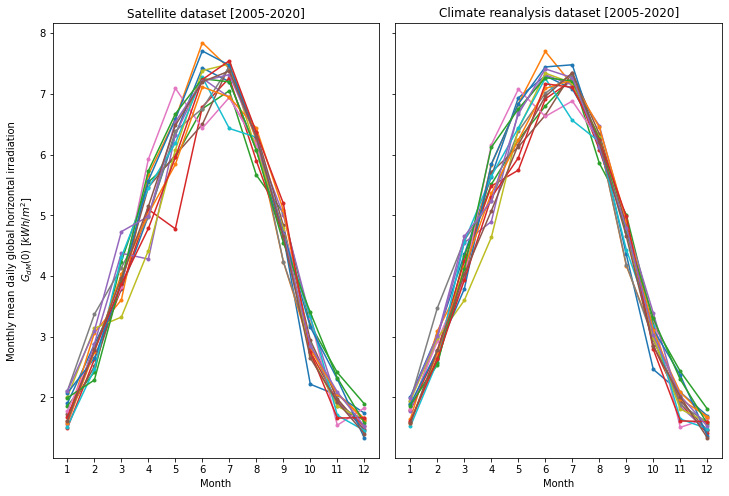

In [18]:
fig, (ax_satellite, ax_reanalysis) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8), sharey=True, squeeze=True)
plt.subplots_adjust(wspace=0.05)

satellite_month_series.plot(ax=ax_satellite, style='.-')
ax_satellite.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_satellite.set_xlabel('Month')
ax_satellite.set_ylabel('Monthly mean daily global horizontal irradiation\n $G_{dM}(0)$ [$kWh/m^2]$')
ax_satellite.set_title('Satellite dataset [2005-2020]')
ax_satellite.get_legend().remove()

reanalysis_month_series.plot(ax=ax_reanalysis, style='.-')
ax_reanalysis.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_reanalysis.set_xlabel('Month')
ax_reanalysis.set_title('Climate reanalysis dataset [2005-2020]')
ax_reanalysis.get_legend().remove()

In [15]:
# std/mean [%] : μ±1σ [68% of monthly interannual deviation explained in the interval]
print('Monthly interannual deviation for reanalysis data')
print(round(reanalysis_month_series.std(axis='columns') / reanalysis_month_series.mean(axis='columns') * 100,2))

print('Monthly interannual deviation for satellite data')
print(round(satellite_month_series.std(axis='columns') / satellite_month_series.mean(axis='columns') * 100))

Monthly interannual deviation for reanalysis data
time
1      9.33
2      8.66
3      7.42
4      7.63
5      5.86
6      4.16
7      2.96
8      2.32
9      5.57
10     7.64
11    13.20
12     8.41
dtype: float64
Monthly interannual deviation for satellite data
time
1     12.0
2     10.0
3      8.0
4      9.0
5      8.0
6      6.0
7      4.0
8      3.0
9      6.0
10    11.0
11    12.0
12    10.0
dtype: float64
